# 학습 개선방향
### 데이터 
- `04_08_FE_.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
### 검증 전략 단순화 및 통일
- `05_07_lgbm_v1.ipynb`에서 사용한 가중평균을 통한 검증 대신, `date_block_num` = 34에 가장 가깝고 영향이 큰 `date_block_num` = 33을 검증셋으로 사용하여 학습
### Seed Averaging
- 최종 학습 모델에서 하이퍼 파라미터를 파라미터를 고정하고, seed를 변환하여 5회 학습하여 평균을 취하여 최종 모델을 생성

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import optuna
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

%matplotlib inline
plt.style.use("seaborn-v0_8-white")

# Data

In [2]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data2.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')
all_data.shape

(8026950, 58)

# Model

## prepare

In [3]:
train_mask = all_data['date_block_num'] <= 32
x_train = all_data.loc[train_mask].drop(['item_cnt_month'], axis=1)

val_mask = all_data['date_block_num'] == 33
x_val = all_data.loc[val_mask].drop(['item_cnt_month'], axis=1)

y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)

all_mask = all_data['date_block_num'] <= 33
x_all = all_data.loc[all_mask].drop(['item_cnt_month'], axis=1)
y_all = all_data.loc[all_mask, 'item_cnt_month'].clip(0, 20)

test_mask = all_data['date_block_num'] == 34
x_test = all_data.loc[test_mask].drop(['item_cnt_month'], axis=1)

In [4]:
cat_features = ['shop_id', 'shop_type', 'type', 'subtype', 'item_category_id', 'city', 'month']
dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

## optuna

In [7]:
%%time
fixed_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'feature_pre_filter': False,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'num_leaves': trial.suggest_int('num_leaves', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10)
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1500,
        valid_sets=[dval],
        valid_names=['eval'],
        callbacks=[
            early_stopping(stopping_rounds=150, verbose=False),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    trial.set_user_attr("best_iter", lgb_model.best_iteration)
    
    preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration).clip(0, 20)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

[I 2025-12-04 14:49:17,613] A new study created in memory with name: no-name-2153820f-cc29-4662-960b-c0b458e3c580


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-04 14:52:58,173] Trial 0 finished with value: 0.7920932837703991 and parameters: {'num_leaves': 127, 'learning_rate': 0.03862083925763863, 'feature_fraction': 0.9663028199432513, 'bagging_fraction': 0.7227840820237976, 'bagging_freq': 4}. Best is trial 0 with value: 0.7920932837703991.
[I 2025-12-04 14:59:53,501] Trial 1 finished with value: 0.7844619662629941 and parameters: {'num_leaves': 151, 'learning_rate': 0.02271629970193425, 'feature_fraction': 0.7463084687531312, 'bagging_fraction': 0.9821192096250286, 'bagging_freq': 9}. Best is trial 1 with value: 0.7844619662629941.
[I 2025-12-04 15:03:48,579] Trial 2 finished with value: 0.7840386749826583 and parameters: {'num_leaves': 191, 'learning_rate': 0.031624822084432416, 'feature_fraction': 0.5208589864093756, 'bagging_fraction': 0.8847289359689058, 'bagging_freq': 1}. Best is trial 2 with value: 0.7840386749826583.
[I 2025-12-04 15:07:00,908] Trial 3 finished with value: 0.7921459909829359 and parameters: {'num_leaves'

In [12]:
print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Iteration : {study_lgbm.best_trial.user_attrs['best_iter']}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('=='*20,'Best Parameters', '=='*20)
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

Total Trials : 30
Best Trial : 21
Best Iteration : 193
Best Score : 0.77485
======================================== Best Parameters ========================================
num_leaves : 236
learning_rate : 0.04687866174542337
feature_fraction : 0.6291211975984526
bagging_fraction : 0.5110950884009626
bagging_freq : 10


/tmp/ipykernel_45392/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

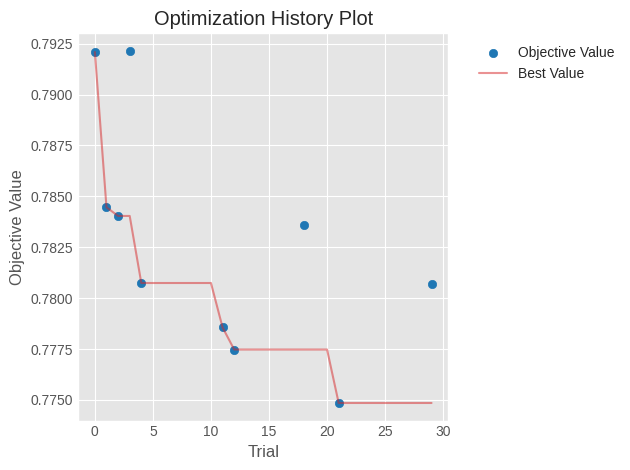

In [13]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_45392/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

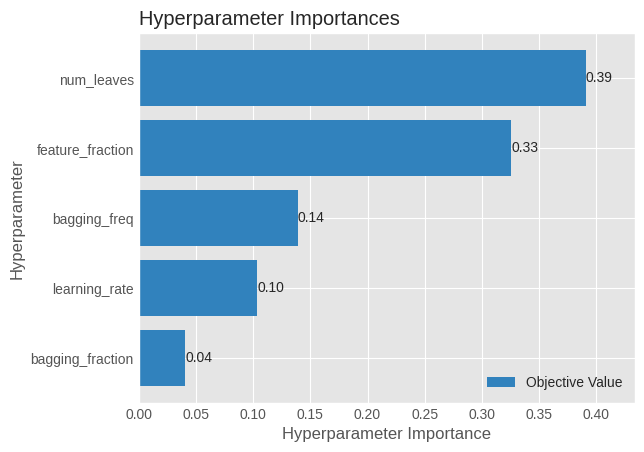

In [14]:
plot_param_importances(study_lgbm)

## validation

In [15]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)

In [16]:
%%time
val_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=1500,
    valid_sets=[dval],
    valid_names=['eval'],
    callbacks=[
        log_evaluation(period=100),
        early_stopping(stopping_rounds=150, verbose=False)
    ]
)

[100]	eval's rmse: 0.779402
[200]	eval's rmse: 0.775131
[300]	eval's rmse: 0.775801
CPU times: user 8min 3s, sys: 906 ms, total: 8min 4s
Wall time: 2min 7s


In [17]:
print('Best score: ', val_lgbm_model.best_score['eval']['rmse'])
print('Best iteration: ', val_lgbm_model.best_iteration)

Best score:  0.7749218217269271
Best iteration:  193


/tmp/ipykernel_45392/1972124855.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


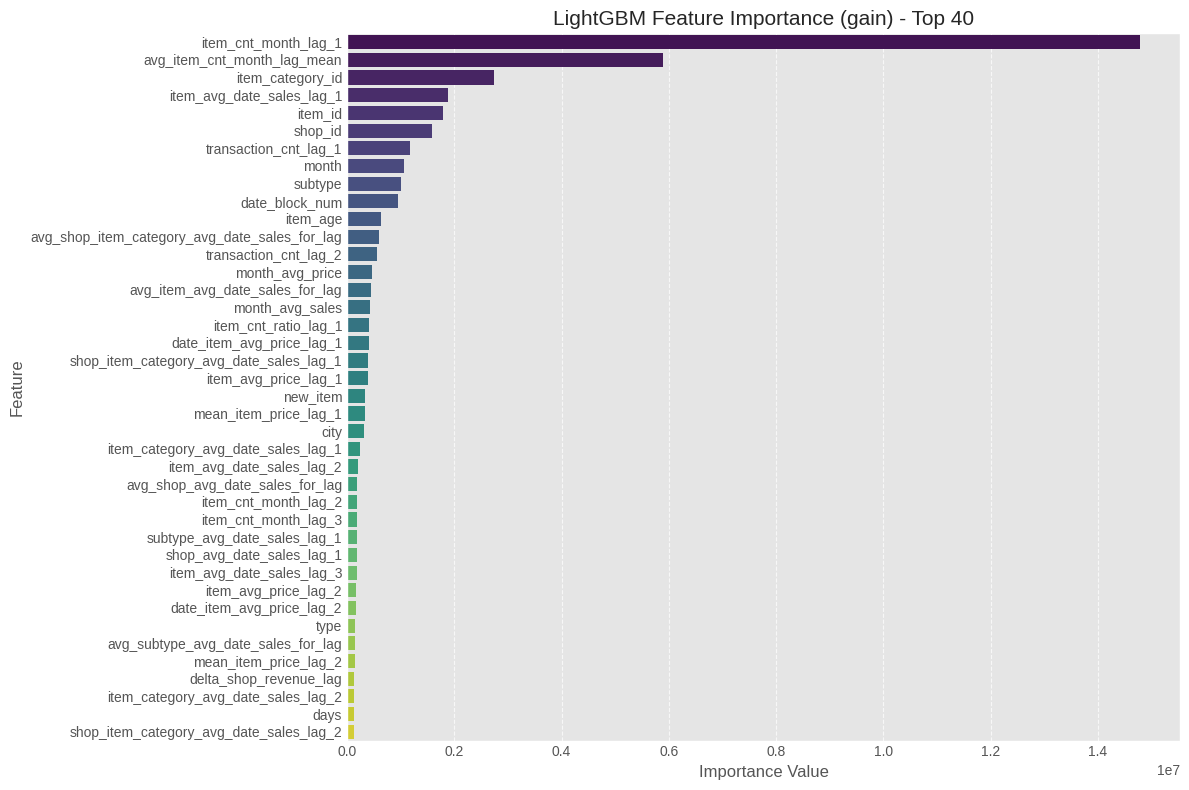

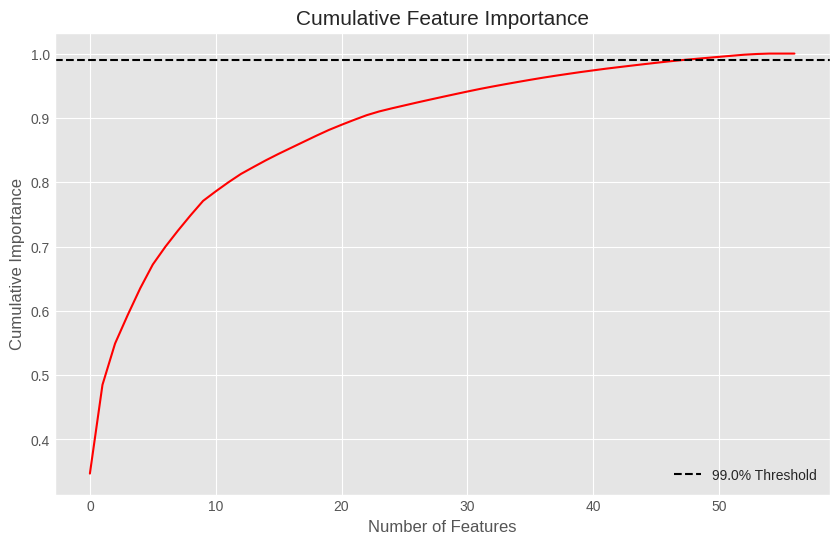

[GAIN] 분석 결과:
- 전체 피처 수: 57
- 99.0% 중요도를 설명하는 피처 수: 49
- 제거 추천 피처 수: 8
drop_cols :  ['shop_avg_date_sales_lag_3', 'date_item_avg_price_lag_3', 'mean_item_price_lag_3', 'item_cnt_ratio_lag_3', 'subtype_avg_date_sales_lag_3', 'shop_type', 'avg_item_price_lag_mean', 'delta_price_lag']


In [18]:
def analyze_and_filter_features(model, importance_type='gain', cum_threshold=0.99):
    if isinstance(model, lgb.Booster):
        importance = model.feature_importance(importance_type=importance_type)
        feature_names = model.feature_name()
    else:
        importance = model.booster_.feature_importance(importance_type=importance_type)
        feature_names = model.booster_.feature_name()
        
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    feature_imp['normalized_importance'] = feature_imp['importance'] / feature_imp['importance'].sum()
    feature_imp['cumulative_importance'] = feature_imp['normalized_importance'].cumsum()
    

    plt.figure(figsize=(12, 8))    
    sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')
    plt.title(f'LightGBM Feature Importance ({importance_type}) - Top 40', fontsize=15)
    plt.xlabel('Importance Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_imp.index, feature_imp['cumulative_importance'], 'r-')
    plt.axhline(y=cum_threshold, color='k', linestyle='--', label=f'{cum_threshold*100}% Threshold')
    plt.title('Cumulative Feature Importance', fontsize=15)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    cutoff_index = feature_imp[feature_imp['cumulative_importance'] > cum_threshold].index[0]
    selected_features = feature_imp.loc[:cutoff_index, 'feature'].tolist()
    removed_features = feature_imp.loc[cutoff_index+1:, 'feature'].tolist()
    
    print(f"[{importance_type.upper()}] 분석 결과:")
    print(f"- 전체 피처 수: {len(feature_imp)}")
    print(f"- {cum_threshold*100}% 중요도를 설명하는 피처 수: {len(selected_features)}")
    print(f"- 제거 추천 피처 수: {len(removed_features)}")
    
    return feature_imp, selected_features, removed_features

df_imp, keep_cols, drop_cols = analyze_and_filter_features(val_lgbm_model, importance_type='gain', cum_threshold=0.99)
print('drop_cols : ', drop_cols)

## train

In [19]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(val_lgbm_model.best_iteration * 1.1)

In [20]:
%%time
seed_full = [42, 1347, 2025]
model_list = []

for i, seed in enumerate(seed_full):
    curr_params = best_params.copy()
    curr_params['random_state'] = seed
    print(f"\n[Training Model {i+1}/{len(seed_full)}] Seed: {seed}")
    final_lgbm_model = lgb.train(
        params=curr_params,
        train_set=dtrain_all,
        num_boost_round=final_iter,
        valid_sets=[dtrain_all],
        callbacks=[
            log_evaluation(period=100)
        ]
    )
    
    file_name = f'05_07_lgbm_model_v2_seed_{seed}.txt'    
    final_lgbm_model.save_model(data_path + file_name)
    model_list.append(final_lgbm_model)


[Training Model 1/3] Seed: 42
[100]	training's rmse: 0.768874
[200]	training's rmse: 0.738059

[Training Model 2/3] Seed: 1347
[100]	training's rmse: 0.770133
[200]	training's rmse: 0.738735

[Training Model 3/3] Seed: 2025
[100]	training's rmse: 0.771722
[200]	training's rmse: 0.740027
CPU times: user 17min 33s, sys: 7.7 s, total: 17min 41s
Wall time: 4min 48s


# prediction

In [21]:
final_preds = np.zeros(len(x_test))

for model in model_list:
    preds = model.predict(x_test).clip(0, 20)
    final_preds += preds
    
final_preds /= len(model_list)

In [22]:
sub['item_cnt_month'] = final_preds.clip(0, 20)
sub.head()

,ID,item_cnt_month
0,0,0.511284
1,1,0.324670
2,2,0.914550
3,3,0.430234
4,4,1.988084


In [24]:
print(pd.Series(final_preds).describe())

count    214200.000000
mean          0.292352
std           0.838372
min           0.000000
25%           0.024069
50%           0.079392
75%           0.249798
max          20.000000
dtype: float64


In [25]:
sub.to_csv(data_path + 'submssion_lgbm_model.csv', index=False)

In [26]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submssion_lgbm_model.csv" -m "05_07_submssion_v2"

100%|██████████████████████████████████████| 5.25M/5.25M [00:00<00:00, 12.3MB/s]
Successfully submitted to Predict Future Sales

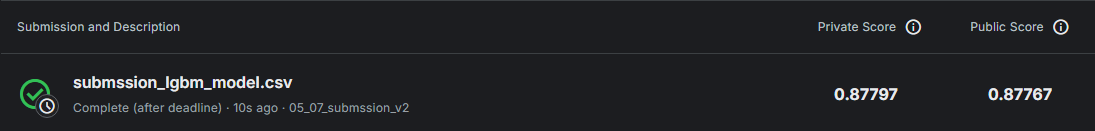
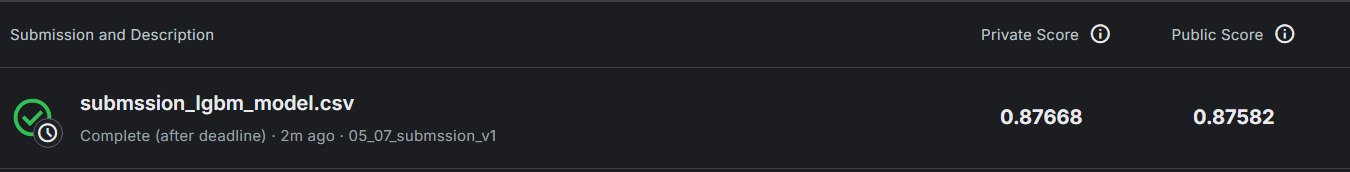